In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge

In [16]:
# Load data into dataframe and remove rows containing NA values

file = 'https://raw.githubusercontent.com/mwaskom/seaborn-data/master/penguins.csv'
penguins = pd.read_csv(file, sep=',', header=0)

penguins_clean = penguins.dropna()

In [17]:
# Check out the head of the dataframe

penguins_clean.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,MALE
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,FEMALE
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,FEMALE
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,FEMALE
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,MALE


In [18]:
# Define features (X) and target (Y), print dimensions

X = penguins_clean[['bill_length_mm', 'bill_depth_mm', 'flipper_length_mm']]
y = penguins_clean['body_mass_g']

print('X has shape:', X.shape)
print('y has shape:', y.shape)

X has shape: (333, 3)
y has shape: (333,)


In [19]:
# Split features and targets data into train and test sets at an 80/20 split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=.2)

In [20]:
# Instantiate and train ridge regression model with a lamba of 1.0

model = Ridge(alpha=1.0).fit(X_train, y_train)

In [21]:
# Defines the mean squared error function

def mse(y_pred, y_actual):
    n = len(y_actual)
    return 1/n*sum((y_pred-y_actual)**2)

In [23]:
# Print mean standard error on training data for our model 

print('Mean Squared Error on training data for initial model:', mse(model.predict(X_train), y_train))

Mean Squared Error on training data for initial model: 150302.8704551265


In [24]:
# Define five by two validation frunction

def FiveByTwo_Validation(train_data, train_targets, lam_vals):
    n = train_data.shape[0]
    res = np.zeros((10, len(lam_vals)))
    for j, lam in enumerate(lam_vals):
        for i in range(5):

            # shuffle data
            shuffle_ix = np.random.choice(n, size=n, replace=False)
            shuffled = train_data.iloc[shuffle_ix, :]
            tgt_shuffled = train_targets.iloc[shuffle_ix]

            # split evenly into train / valid
            train = shuffled.iloc[:int(np.floor(n/2)), :]
            ttgt = tgt_shuffled[:int(np.floor(n/2))]
            valid = shuffled.iloc[int(np.floor(n/2)):, :]
            vtgt = tgt_shuffled[int(np.floor(n/2)):]

            # fit model on train
            model = Ridge(alpha=lam).fit(train, ttgt)
            
            # predict on valid
            preds = model.predict(valid)

            # compute error
            res[2*i, j] = mse(preds, vtgt)
            
            # now swap: train on "validation" set and predict on "train" set
            model_swap = Ridge(alpha=lam).fit(valid, vtgt)
            preds_swap = model_swap.predict(train)
            res[2*i+1, j] = mse(preds_swap, ttgt)
        
    return res

In [25]:
# Calculate the five by two validation scores for a range of lamba values

lam_vals = np.logspace(-2,4,19)
validation_results = FiveByTwo_Validation(X_train, y_train, lam_vals)

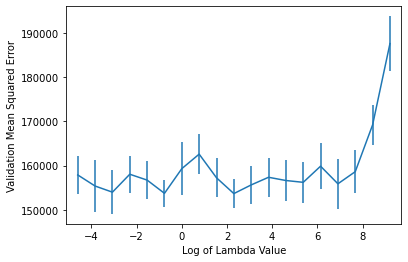

In [26]:
# Plot results

plt.errorbar(np.log(lam_vals), validation_results.mean(axis=0), 
             validation_results.std(axis=0)/np.sqrt(validation_results.shape[0]))
plt.xlim([np.log(lam_vals[0])-.5, np.log(lam_vals[-1])+.5])
plt.xlabel('Log of Lambda Value')
plt.ylabel('Validation Mean Squared Error')
plt.show()

In [27]:
# Select best choice of lambda and print

best_lam_ix = np.argmin(np.mean(validation_results, axis=0))
best_lam = lam_vals[best_lam_ix]

print('Best choice of lambda:', best_lam)

Best choice of lambda: 10.0


In [28]:
# Instantiate and train ridge regression model with our optimal choice of lambda

best_model = Ridge(alpha=best_lam).fit(X_train, y_train)

In [29]:
# Print mean standard error on test data for our optimal model

print('Mean Squared Error on test data for optimal model:', mse(best_model.predict(X_test), y_test))

Mean Squared Error on test data for optimal model: 165145.3167065845
